## ARIMA

In [1]:
Path = 'Sheet_metal_mng.csv'

ARIMA Mean Squared Error: 311.39969788105327
ARIMA Root Mean Squared Error: 17.64652084352758
Price Mean: 163.1156708
Prediction Price Mean: 311.0610724


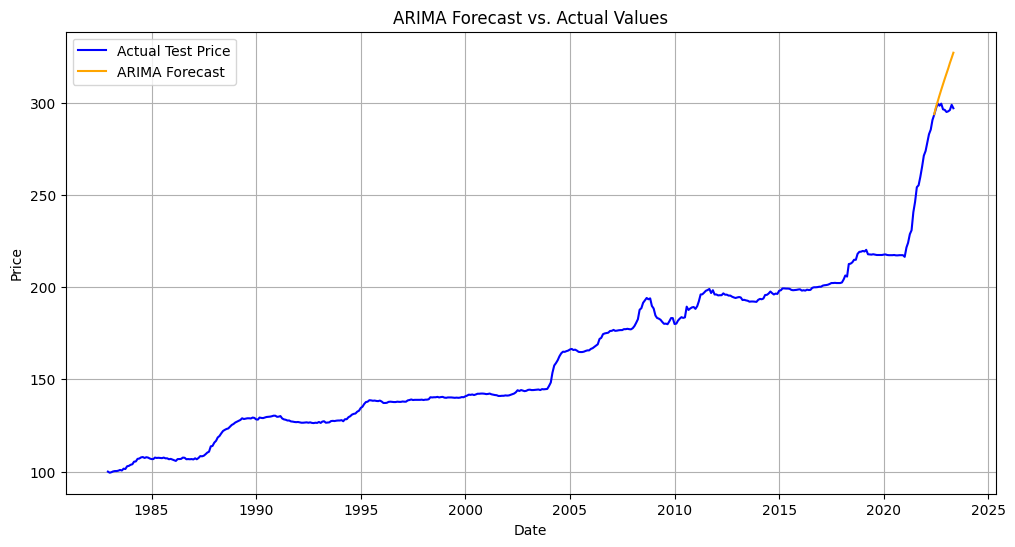

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from sklearn.metrics import mean_squared_error
import math

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load specific forecasting tools



df = pd.read_csv(Path,index_col='Date',parse_dates=True)
df.index.freq = 'MS'

train = df.iloc[:-12]  # All except the last 12 rows
test = df.iloc[-12:]   # Last 12 rows for testing

# import random
# ARIMA Model
def arima_forecast(train_series):
    model = auto_arima(train_series,seasonal=True)
    order = model.order
    model = ARIMA(train_series, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=len(test))
    return forecast

# Call ARIMA function
arima_predictions = arima_forecast(train['Price'])

# Calculate ARIMA MSE and RMSE
arima_mse = mean_squared_error(test['Price'], arima_predictions)
arima_rmse = np.sqrt(arima_mse)

print("ARIMA Mean Squared Error:", arima_mse)
print("ARIMA Root Mean Squared Error:", arima_rmse)
print(f'Price Mean: {df.Price.mean():11.10}')
print(f'Prediction Price Mean: {arima_predictions.mean():11.10}')

# Plotting the ARIMA forecast and actual test values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], color='blue', label='Actual Test Price')  # Plotting actual values
plt.plot(arima_predictions.index, arima_predictions, color='orange', label='ARIMA Forecast')  # Plotting ARIMA forecast
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast vs. Actual Values')
plt.legend()
plt.grid()
plt.show()

## Monte Carlo

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_squared_error

# Define the maximum historical data period to consider (in years)
years = 3

# Define your DataFrame 'df' containing historical price data

# Calculate the maximum historical data period based on the number of data points
max_history_years = df.shape[0] // 12

# Initialize variables to track the minimum RMSE and its corresponding year
min_rmse = float('inf')
best_year = None

# Initialize lists to store results
rmse_values = []
years_list = []

# Define the monte_carlo_forecast function
def monte_carlo_forecast(price_series, expected_return, volatility, num_simulations, num_periods):
    simulations = np.zeros((num_simulations, num_periods))
    simulations[:, 0] = price_series.iloc[-1]  # Start simulations from the last available price

    for i in range(num_simulations):
        for j in range(1, num_periods):
            random_num = random.gauss(0, 1)
            drift = expected_return * simulations[i, j - 1]
            shock = volatility * random_num * simulations[i, j - 1]
            simulations[i, j] = simulations[i, j - 1] + drift + shock

    forecast_dates = pd.date_range(start=price_series.index[-1], periods=num_periods, freq=price_series.index.freq)
    forecast_df = pd.DataFrame(simulations, index=range(num_simulations), columns=forecast_dates)

    return forecast_df

# Define the monte_carlo_simulation function with additional return value
def monte_carlo_simulation(df, years_back):
    # Select historical data for the specified number of years
    train = df.iloc[-(years_back * 12 + 1):-12]  # Use the last "years_back" years of data for training
    test = df.iloc[-12:]  # Last 12 months for testing

    historical_returns = train['Price'].pct_change().dropna()
    historical_monthly_volatility = historical_returns.groupby(by=[historical_returns.index.month]).std()
    historical_avg_return_monthly = historical_returns.groupby(by=[historical_returns.index.month]).mean()

    num_simulations = 1000
    num_periods = 12
    all_forecasts = pd.DataFrame()
    
    for month in range(1, 13):
        expected_return = historical_avg_return_monthly[month]  # Use `month` directly as the index
        volatility = historical_monthly_volatility[month]  # Use `month` directly as the index
        forecast = monte_carlo_forecast(train['Price'], expected_return, volatility, num_simulations, num_periods).T
        forecast_month = forecast[forecast.index.month == month].T
        all_forecasts[month] = forecast_month

    # Rename the columns with the corresponding month names
    month_names = ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
                   '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
                   '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01']
    all_forecasts.columns = pd.to_datetime(month_names)
    all_forecasts = all_forecasts.sort_index(axis=1)

    # Calculate Monte Carlo RMSE
    MonteCarlo_mse = mean_squared_error(test['Price'], all_forecasts.mean().values)
    MonteCarlo_rmse = np.sqrt(MonteCarlo_mse)

    # Return both RMSE and all_forecasts
    return MonteCarlo_rmse, all_forecasts

# Loop through different historical data periods
for years_back in range(years, max_history_years + 1):
    # Call the monte_carlo_simulation function and store the RMSE and forecasts
    MonteCarlo_rmse, all_forecasts = monte_carlo_simulation(df, years_back)
    
    # Append results to lists
    rmse_values.append(MonteCarlo_rmse)
    years_list.append(years_back)
    
    # Check if the current RMSE is the smallest found so far
    if MonteCarlo_rmse < min_rmse:
        min_rmse = MonteCarlo_rmse
        best_year = years_back

# Print the least RMSE and its corresponding year
print(f"The least RMSE is {min_rmse} which is for year {best_year}.")

# You can access the all_forecasts DataFrame here for further analysis


The least RMSE is 4.162306652301478 which is for year 37.


In [4]:
# all_forecasts

Monte Carlo RMSE Error: 4.288986286910609


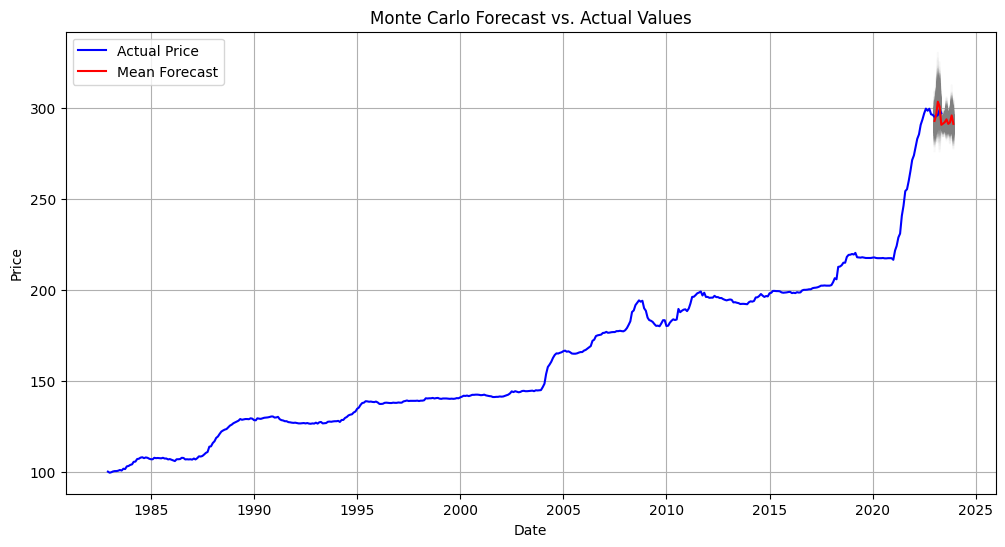

In [5]:
monte_carlo_simulation(df, years_back)
print('Monte Carlo RMSE Error:',MonteCarlo_rmse)
# Plotting the forecast and actual values
plt.figure(figsize=(12, 6))
plt.plot(all_forecasts.T, color='gray', alpha=0.05)  # Plotting all simulations
plt.plot(df.index, df['Price'], color='blue', label='Actual Price')  # Plotting actual values
plt.plot(all_forecasts.columns, all_forecasts.mean(), color='red', label='Mean Forecast')  # Plotting mean forecast
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Monte Carlo Forecast vs. Actual Values')
plt.legend()
plt.grid()
plt.show()

## Econometrics

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# GDP
df1 = pd.read_csv('Econometric/GDP.csv')
# convert to period
df1['DATE'] = pd.to_datetime(df1['DATE']).dt.to_period('M')
# set Date as index and resample
df1 = df1.set_index('DATE').resample('M').interpolate()
df1.index = df1.index.to_timestamp()
# Total Construction Spending: Total Construction in the United States 
df2 = pd.read_csv('Econometric/TTLCONS.csv', index_col='DATE',parse_dates=True)
df2.index.freq = 'MS'
df2['TTLCONS'] = df2['TTLCONS']/1000
# Domestic Auto Production
df3 =  pd.read_csv('Econometric/DAUPSA.csv', index_col='DATE',parse_dates=True)
# Industrial Production: Total Index 
df4 =  pd.read_csv('Econometric/INDPRO.csv', index_col='DATE',parse_dates=True)
# Price of Commodity
df5 = pd.read_csv(Path, index_col='Date',parse_dates=True)
df5 = df5.rename_axis('DATE')

# Concatenate the DataFrames along rows using pd.concat()
data_frames = [df1, df2, df3, df4, df5]
df = pd.concat(data_frames, axis=1, join='inner')  # 'inner' join retains only mutual dates
# Data Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Initialize the StandardScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Fit the scaler to the DataFrame and transform it
scaled_data = scaler.fit_transform(df[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']])

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=df[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']].columns, index=df[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']].index)
data_frames = [scaled_df, df['Price']]

scaled_df = pd.concat(data_frames, axis=1, join='inner')  # 'inner' join retains only mutual dates

## OLS

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1932.
Date:                Thu, 14 Sep 2023   Prob (F-statistic):          1.17e-235
Time:                        12:39:20   Log-Likelihood:                -1181.7
No. Observations:                 352   AIC:                             2373.
Df Residuals:                     347   BIC:                             2393.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.4733      3.312     42.409      0.0

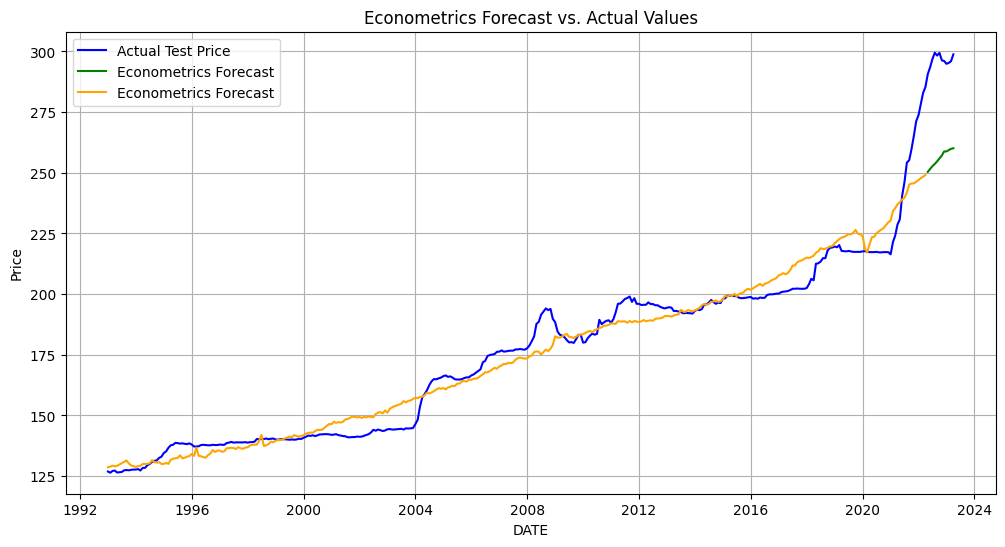

In [7]:
train = scaled_df.iloc[:-12]  # All except the last 12 rows
test = scaled_df.iloc[-12:]   # Last 12 rows for testing

# Define the dependent variable (MetalSheetDemand) and independent variables
y_train = train['Price']
X_train = train[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']]
X_test = test[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']]
y_test = test['Price']

# Add a constant term to the independent variables
X_train = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train)
results = model.fit()

# Print the model summary
print(results.summary())

# Forecast future outcomes
# forecast_X = test[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']] 
X_test = sm.add_constant(X_test) 
forecasted_Price = results.predict(X_test)

forecasted_train = results.predict(X_train)

# Calculate MSE and RMSE
Eco_mse = mean_squared_error(test['Price'], forecasted_Price)
Eco_rmse = np.sqrt(Eco_mse)

print("\n\n")
print("Econometrics Forecast Mean Squared Error:", Eco_mse)
print("Econometrics Forecast Root Mean Squared Error:", Eco_rmse)
print(f'Price Mean: {scaled_df.Price.mean():11.10}')
print(f'Prediction Price Mean: {forecasted_Price.mean():11.10}')

# Plotting the forecast and actual test values
plt.figure(figsize=(12, 6))
plt.plot(scaled_df.index, scaled_df['Price'], color='blue', label='Actual Test Price')  # Plotting actual values
plt.plot(forecasted_Price.index, forecasted_Price, color='green', label='Econometrics Forecast')  # Plotting Econometrics forecast
plt.plot(forecasted_train.index, forecasted_train, color='orange', label='Econometrics Forecast')  # Plotting Econometrics train forecast
plt.xlabel('DATE')
plt.ylabel('Price')
plt.title('Econometrics Forecast vs. Actual Values')
plt.legend()
plt.grid()
plt.show()

## ML LinearRegression




Econometrics Forecast Mean Squared Error: 1627.9675764393262
Econometrics Forecast Root Mean Squared Error: 40.348080207605
Price Mean: 178.3024176
Prediction Price Mean:  256.075671


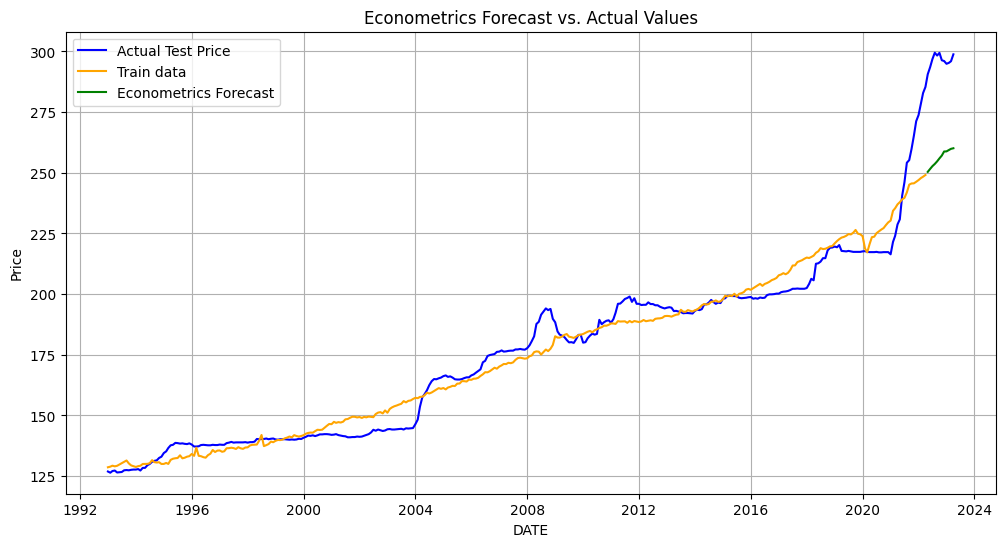

In [8]:
from sklearn.linear_model import LinearRegression

train = scaled_df.iloc[:-12]  # All except the last 12 rows
test = scaled_df.iloc[-12:]   # Last 12 rows for testing

# Define the dependent variable (MetalSheetDemand) and independent variables
y_train = train['Price']
X_train = train[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']]
X_test = test[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']]
y_test = test['Price']

model = LinearRegression()
model.fit(X_train, y_train)

# Predict the model
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
# Calculate MSE and RMSE
Eco_mse = mean_squared_error(y_test, y_pred)
Eco_rmse = np.sqrt(Eco_mse)

print("\n\n")
print("Econometrics Forecast Mean Squared Error:", Eco_mse)
print("Econometrics Forecast Root Mean Squared Error:", Eco_rmse)
print(f'Price Mean: {scaled_df.Price.mean():11.10}')
print(f'Prediction Price Mean: {y_pred.mean():11.10}')

# Plotting the ARIMA forecast and actual test values
plt.figure(figsize=(12, 6))
plt.plot(scaled_df.index, scaled_df['Price'], color='blue', label='Actual Test Price')  # Plotting actual values
plt.plot(y_train.index, y_pred_train, color='orange', label='Train data')  # Plotting Econometrics forecast
plt.plot(y_test.index, y_pred, color='green', label='Econometrics Forecast')  # Plotting Econometrics forecast
plt.xlabel('DATE')
plt.ylabel('Price')
plt.title('Econometrics Forecast vs. Actual Values')
plt.legend()
plt.grid()
plt.show()


In [9]:
# Create lists or arrays for RMSE values and corresponding values
rmse_values = ['ARIMA', 'MonteCarlo', 'Econometrics']  
corresponding_values = [arima_rmse, MonteCarlo_rmse, Eco_rmse]  

# Create a DataFrame
data = {'Model': rmse_values, 'RMSE': corresponding_values}
df = pd.DataFrame(data)
# Set "Model" as the index
df.set_index('Model', inplace=True)

print("Here is the rmse error for:", Path)
# Display the DataFrame
print(df)

Here is the rmse error for: Sheet_metal_mng.csv
                   RMSE
Model                  
ARIMA         17.646521
MonteCarlo     4.288986
Econometrics  40.348080
